In [2]:
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

# importing data
df = pd.read_csv('../data/data_scientist_Fraud_20241009.csv')
print('shape of dataframe', df.shape)
df.head()

shape of dataframe (13239, 20)


,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age
0,NaN,1,ip_1,iPhone OS,13.0,2021-04-28 13:40:40.642000,Red Shop,consumer_1170,2021-03-26 11:52:01.881000,4370,email_0000002076@docomo.ne.jp,email_0000002076@docomo.ne.jp,818000003108,818000003108,106,345,3480,1204011,Male,39
1,NaN,2,ip_2,iPhone OS,13.0,2021-04-30 19:11:16.507000,Red Shop,consumer_6145,2021-04-30 19:10:21.403000,1350,email_000000005732@icloud.com,email_000000005732@icloud.com,818000002287,818000002287,110,0,0,1155022,Female,29
2,NaN,3,ip_2,iPhone OS,13.0,2021-04-30 19:10:06.264000,Red Shop,consumer_6145,2021-04-30 19:10:21.403000,1350,email_000000005732@icloud.com,email_000000005732@icloud.com,818000002287,818000002287,1,0,0,1155022,Male,42
3,NaN,4,ip_3,Android,8.0,2021-04-30 09:04:22.531000,Blue Shop,consumer_5619,2021-04-30 09:04:40.176000,7250,email_0000000000000001070@yahoo.co.jp,email_0000000000000001070@yahoo.co.jp,819000005271,819000005271,200,0,0,5848915,Female,52
4,NaN,5,ip_4,iPhone OS,13.0,2021-05-05 15:26:28.023000,Red Shop,consumer_1318,2021-04-10 12:29:29.287000,16492,email_006289@i.softbank.jp,email_006289@i.softbank.jp,818000002516,818000002516,144,567,20000,1155816,Female,26


In [3]:
df.describe()

,fraud_flag,payment_id,version,amount,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_age
count,69.0,13239.000000,13152.000000,13239.000000,1.323900e+04,1.323900e+04,13239.000000,13239.000000,13239.000000,1.323900e+04,13239.000000
mean,1.0,6620.000000,11.723084,12846.151824,8.181809e+11,8.182766e+11,99.303346,181.813506,3425.685701,5.266893e+06,42.934965
std,0.0,3821.914442,2.060552,17043.902625,2.088131e+09,6.388668e+08,57.750382,368.528096,11895.793527,2.692966e+06,15.851062
min,1.0,1.000000,4.000000,1.000000,7.097000e+11,8.170000e+11,1.000000,0.000000,0.000000,1.000812e+06,16.000000
25%,1.0,3310.500000,10.000000,2850.000000,8.180000e+11,8.180000e+11,49.000000,0.000000,0.000000,3.332931e+06,29.000000
50%,1.0,6620.000000,13.000000,6800.000000,8.180000e+11,8.180000e+11,100.000000,0.000000,0.000000,5.378137e+06,43.000000
75%,1.0,9929.500000,13.000000,16192.000000,8.190000e+11,8.190000e+11,149.000000,174.000000,1768.000000,7.478093e+06,56.000000
max,1.0,13239.000000,13.000000,385000.000000,9.055000e+11,8.190000e+11,200.000000,2578.000000,252000.000000,9.998176e+06,70.000000


In [4]:
df.dtypes

fraud_flag                 float64
payment_id                   int64
hashed_ip                   object
device                      object
version                    float64
adjusted_pmt_created_at     object
merchant_name               object
hashed_consumer_id          object
adjusted_acc_created_at     object
amount                       int64
hashed_buyer_email          object
hashed_consumer_email       object
hashed_buyer_phone           int64
hashed_consumer_phone        int64
consumer_phone_age           int64
merchant_account_age         int64
ltv                          int64
hashed_zip                   int64
consumer_gender             object
consumer_age                 int64
dtype: object

## Situation

- On 4/27 afternoon, agents flagged suspicious payments (fraud_flag == 1)
- need to refer to pattern observed in past days and adjust model to reject future fraudulent payment attempts
- dataset is from 4/26 - 5/8
- Red/Blue shope = c2c/flea market service
- assume 4/28 is presentation day

In [5]:
# sort by adjusted_pmt_created_at do get time series in order
df = df.sort_values('adjusted_pmt_created_at', ignore_index=True)

# convert to datetime object
df['adjusted_pmt_created_at'] = pd.to_datetime(df['adjusted_pmt_created_at'])
df.head()

,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age
0,NaN,5860,ip_3737,Android,10.0,2021-04-26 00:00:03.042,Red Shop,consumer_1145,2021-03-25 23:15:19.408000,47500,email_0000000006799@gmail.com,email_0000000006799@gmail.com,819000007698,819000007698,100,358,32500,7508146,NaN,41
1,NaN,2676,ip_1723,Android,10.0,2021-04-26 00:01:33.221,Red Shop,consumer_2022,2021-04-18 03:23:19.562000,580,email_0000000000192@gmail.com,email_0000000000192@gmail.com,818000003244,818000003244,181,19,3800,8518137,Female,56
2,NaN,8149,ip_5156,Android,9.0,2021-04-26 00:04:28.036,Red Shop,consumer_837,2021-03-09 23:46:44.918000,680,email_00000000000000000000004991@docomo.ne.jp,email_00000000000000000000004991@docomo.ne.jp,818000001389,818000001389,126,0,0,9552346,NaN,28
3,NaN,8151,ip_5156,Android,9.0,2021-04-26 00:05:19.697,Red Shop,consumer_837,2021-03-09 23:46:44.918000,680,email_00000000000000000000004991@docomo.ne.jp,email_00000000000000000000004991@docomo.ne.jp,818000001389,818000001389,145,0,0,9552346,Female,21
4,NaN,1342,ip_865,iPhone OS,13.0,2021-04-26 00:05:47.582,Blue Shop,consumer_2336,2021-04-20 19:37:42.313000,125400,email_00000008182@ezweb.ne.jp,email_00000008182@ezweb.ne.jp,818000003618,818000003618,18,0,0,9959594,Male,51


In [6]:
# get rows from datetime column adjust_pmt_created_at are either 2021-4-26 or 2021-4-27
old = df.loc[df['adjusted_pmt_created_at'].dt.day.isin([26, 27])]

# data from day of presentation and after. can be used as hypothetical test data
new = df.loc[~df['adjusted_pmt_created_at'].dt.day.isin([26, 27])]

In [7]:
# number of rows per dataset (pre and post presentation)
print(old.shape, new.shape)

(2191, 20) (11048, 20)


In [8]:
# number of NA in each column
old.isna().sum()

# won't need to impute many missing values. only gender has a decent amount of missing values 23%

fraud_flag                 2122
payment_id                    0
hashed_ip                     0
device                        9
version                       9
adjusted_pmt_created_at       0
merchant_name                 0
hashed_consumer_id            0
adjusted_acc_created_at       0
amount                        0
hashed_buyer_email            0
hashed_consumer_email         0
hashed_buyer_phone            0
hashed_consumer_phone         0
consumer_phone_age            0
merchant_account_age          0
ltv                           0
hashed_zip                    0
consumer_gender             513
consumer_age                  0
dtype: int64

### Going through variables

In [9]:
old.value_counts('fraud_flag', normalize=True, dropna=False)

# 3% of payments were flagged as fraud

fraud_flag
NaN    0.968508
1.0    0.031492
Name: proportion, dtype: float64

In [10]:
old['hashed_ip'].value_counts(dropna=False)
# 1412 unique ip addresses in the old data, most purchases from single ip address is 15

hashed_ip
ip_3833    15
ip_7589    13
ip_4188    12
ip_197     12
ip_7458    11
           ..
ip_671      1
ip_3351     1
ip_1183     1
ip_4840     1
ip_3737     1
Name: count, Length: 1412, dtype: int64

In [11]:
old['device'].value_counts(dropna=False, normalize=True)
# 5 unique devices, majority purchases on iPhone OS (1566)

device
iPhone OS       0.714742
Android         0.221817
Windows NT      0.052031
Mac OS X        0.005021
NaN             0.004108
iPad; CPU OS    0.002282
Name: proportion, dtype: float64

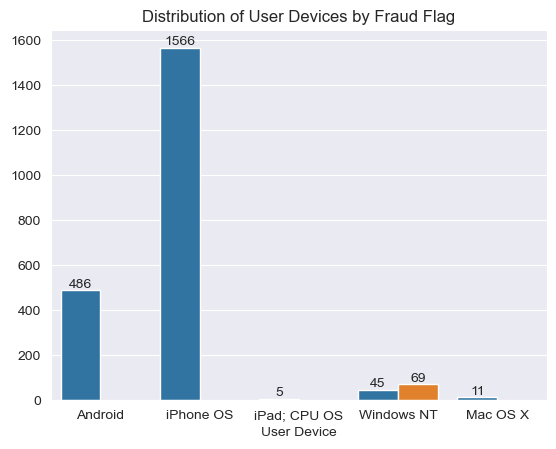

In [43]:
fr = old.copy()
fr['fraud_flag'].fillna(0, inplace=True)
fr['fraud_flag'] = fr['fraud_flag'].astype(int)


ax = sns.countplot(x='device', data=fr, hue='fraud_flag', legend=False)
ax.set(xlabel='User Device',
       ylabel='',
       title='Distribution of User Devices by Fraud Flag')
for container in ax.containers:
    ax.bar_label(container)

<Axes: title={'center': 'Number of Purchases by Device'}, xlabel='device'>

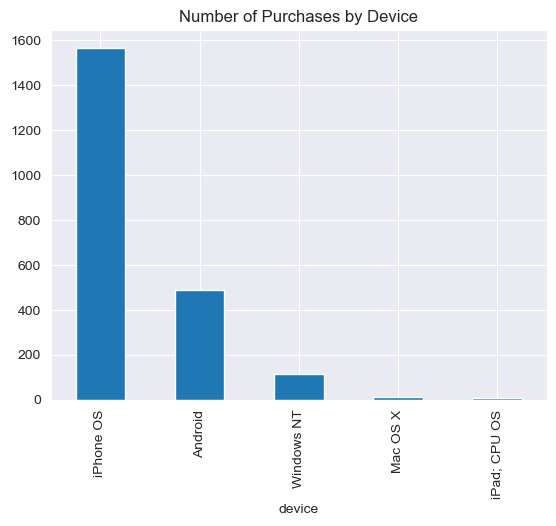

In [13]:
# count plot of devices
old['device'].value_counts().plot(kind='bar', title='Number of Purchases by Device')

<Axes: title={'center': 'Number of Purchases by Device'}, xlabel='device'>

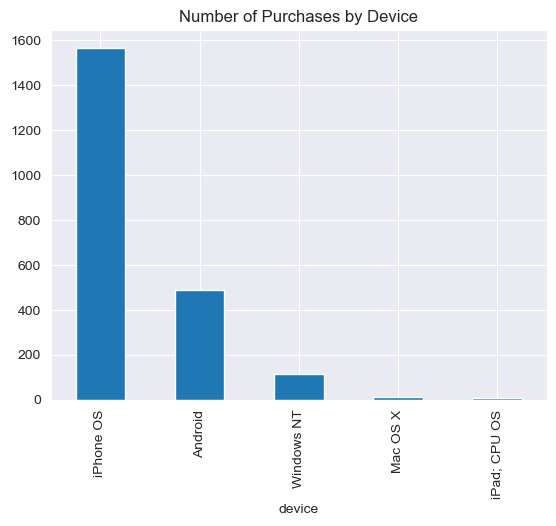

In [14]:
# plot of devices by fraud_flag
old['device'].value_counts().plot(kind='bar', title='Number of Purchases by Device')

In [15]:
# count of purchases by date
old['adjusted_pmt_created_at'].dt.day.value_counts()
# about 1000 per day

adjusted_pmt_created_at
27    1116
26    1075
Name: count, dtype: int64

In [16]:
# count of purchases by hour
old['adjusted_pmt_created_at'].dt.hour.value_counts()
# large majority in evening time, most purchases at 22:00

adjusted_pmt_created_at
22    236
21    209
23    139
20    135
14    126
18    126
16    118
19    111
17    107
0     107
12     99
13     98
15     90
11     77
10     72
1      63
2      53
9      48
7      47
8      40
3      26
6      23
4      23
5      18
Name: count, dtype: int64

<Axes: title={'center': 'Number of Purchases by Hour'}, xlabel='adjusted_pmt_created_at'>

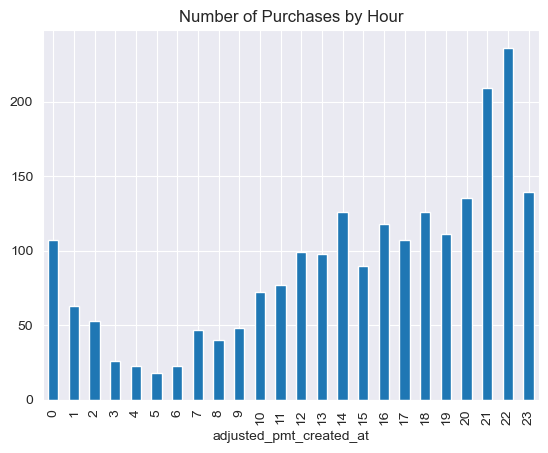

In [17]:
# count plot of purchases by hour
old['adjusted_pmt_created_at'].dt.hour.value_counts(sort=False).plot(kind='bar', title='Number of Purchases by Hour')

In [18]:
# number of purchases from each merchant
old['merchant_name'].value_counts()

merchant_name
Red Shop     1415
Blue Shop     776
Name: count, dtype: int64

<Axes: title={'center': 'Number of Purchases by Merchant'}, xlabel='merchant_name'>

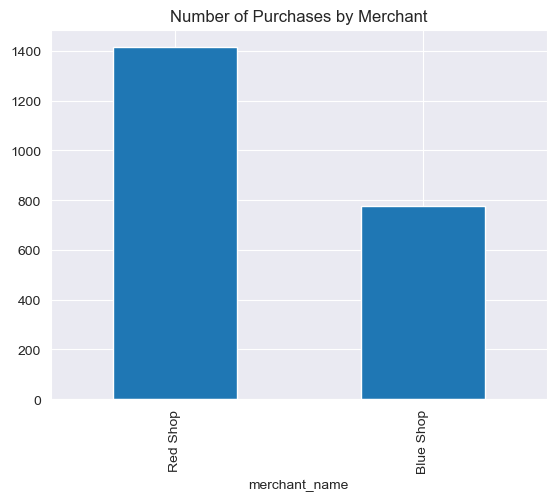

In [19]:
# count plot of purchases by merchant
old['merchant_name'].value_counts().plot(kind='bar', title='Number of Purchases by Merchant')

C:\Users\scott\AppData\Local\Temp\ipykernel_40864\3194545585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old['adjusted_acc_created_at'] = pd.to_datetime(old['adjusted_acc_created_at'])


<Axes: title={'center': 'Number of Accounts Created by Hour'}, xlabel='adjusted_acc_created_at'>

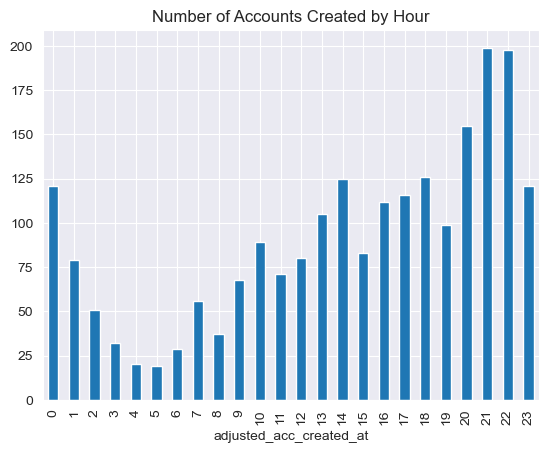

In [20]:
# change to datetime
old['adjusted_acc_created_at'] = pd.to_datetime(old['adjusted_acc_created_at'])

# count of accounts created by hour, sorted by hour
old['adjusted_acc_created_at'].dt.hour.value_counts().sort_index().plot(kind='bar', title='Number of Accounts Created by Hour')

# most accounts created in the evening

<Axes: title={'center': 'Distribution of Transaction Amount'}, ylabel='Frequency'>

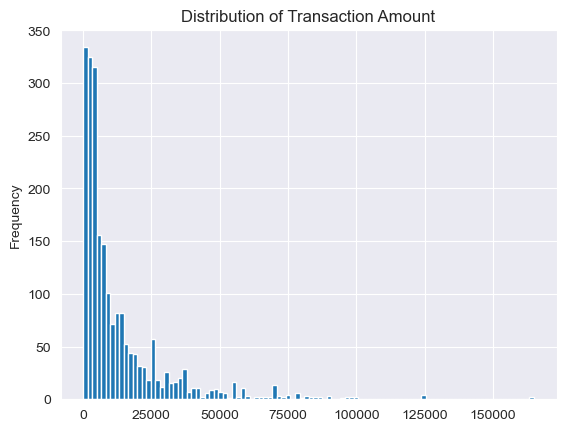

In [21]:
# distribution of transaction amount
old['amount'].plot(kind='hist', bins=100, title='Distribution of Transaction Amount')

In [22]:
# heavy right skew, with few outliers above 100000
old['amount'].describe()

count      2191.000000
mean      13083.477408
std       17540.787230
min         100.000000
25%        2900.000000
50%        6386.000000
75%       16000.000000
max      165000.000000
Name: amount, dtype: float64

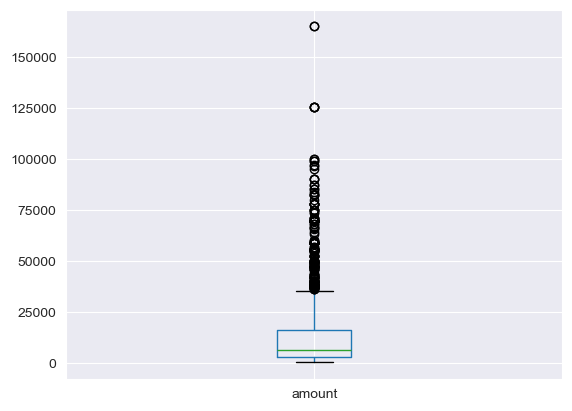

In [23]:
old.boxplot('amount');

In [24]:
old['hashed_buyer_email'].value_counts().head(10)

hashed_buyer_email
email_0000000002719@docomo.ne.jp           15
email_00000003730@gmail.com                15
email_000000003982@gmail.com               13
email_000000000008025@icloud.com           12
email_000002490@au.com                     12
email_0000003549@gmail.com                 11
email_0000003112@i.softbank.jp             10
email_000000000000004109@softbank.ne.jp    10
email_00000000134@gmail.com                 9
email_0000000000762@gmail.com               8
Name: count, dtype: int64

In [25]:
old['hashed_consumer_email'].value_counts().head(10)
# may need to check relationship between consumer and buyer email

hashed_consumer_email
email_00000003730@gmail.com                15
email_0000000002719@docomo.ne.jp           15
email_000000003982@gmail.com               13
email_000002490@au.com                     12
email_000000000000004109@softbank.ne.jp    10
email_0000003112@i.softbank.jp             10
email_000000000008025@icloud.com            9
email_00000000134@gmail.com                 9
email_000000000000003554@gmail.com          8
email_0000004065@icloud.com                 8
Name: count, dtype: int64

In [26]:
old['hashed_consumer_phone'].value_counts().head(10)

hashed_consumer_phone
818000002193    15
819000007415    15
818000003127    13
819000005914    12
818000003789    12
819000005638    10
819000006498    10
818000001128     9
819000007582     8
819000005802     8
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of Consumer Phone Age'}, ylabel='Frequency'>

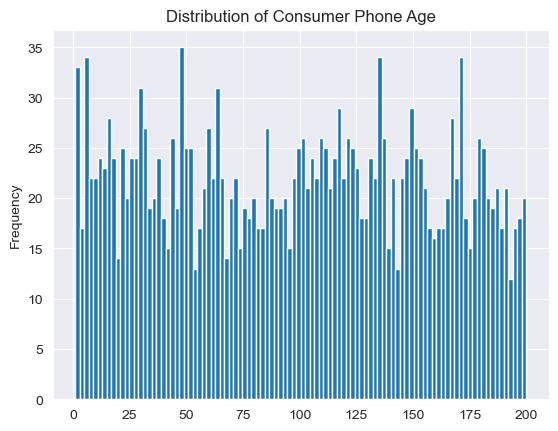

In [27]:
# distribution of consumer phone age (months since the phone was activated)
old['consumer_phone_age'].plot(kind='hist', bins=100, title='Distribution of Consumer Phone Age')

<Axes: title={'center': 'Distribution of Merchant Account Age'}, ylabel='Frequency'>

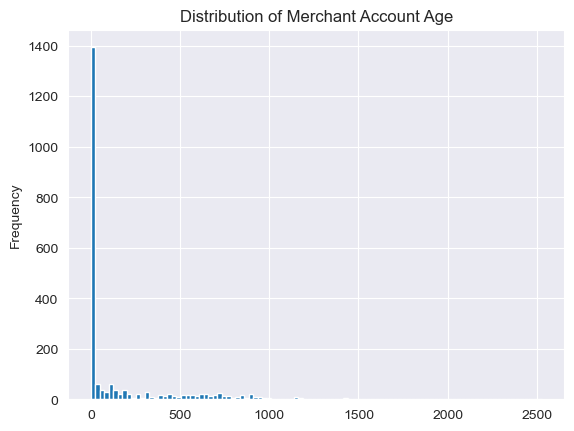

In [28]:
# distribution of merchant account age (number of days since consumer opened account at merchant)
old['merchant_account_age'].plot(kind='hist', bins=100, title='Distribution of Merchant Account Age')

# very heavy right skew, with most values between 0 and 1000

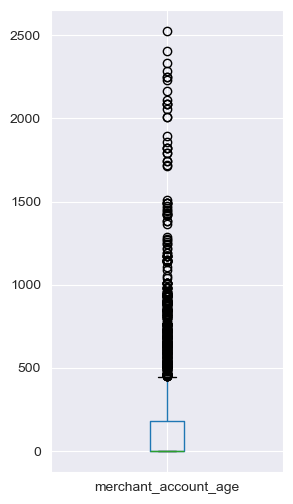

In [29]:
old.boxplot('merchant_account_age', figsize=(3,6));

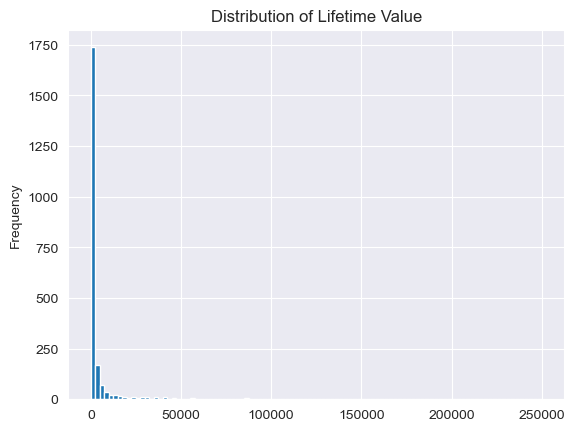

In [30]:
# distribution of lifetime value (ltv) 
old['ltv'].plot(kind='hist', bins=100, title='Distribution of Lifetime Value');

# outliers above 50000

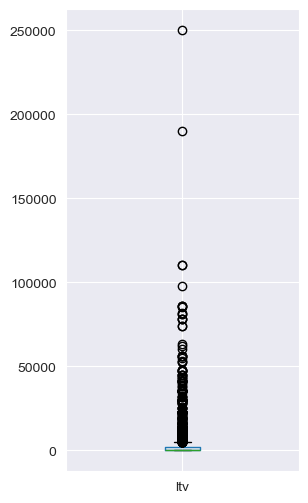

In [31]:
old.boxplot('ltv', figsize=(3,6));

In [32]:
# count of hashed zip code
old['hashed_zip'].value_counts().head(10)

hashed_zip
9831194    15
8598948    15
4268118    13
6909513    12
4858166    12
7198947    11
5528349    10
1241829    10
2918095     9
1153059     9
Name: count, dtype: int64

In [33]:
# count of consumer gender
old['consumer_gender'].value_counts(normalize=True)

# pretty even distribution of male and female consumers

consumer_gender
Female    0.516091
Male      0.483909
Name: proportion, dtype: float64

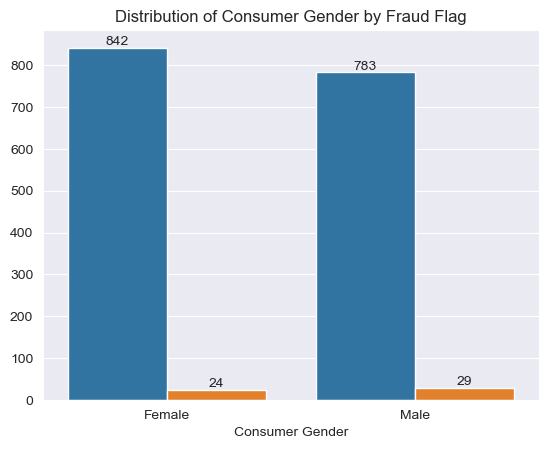

In [41]:
# sns plot of consumer_gender
f = old.copy()
f['fraud_flag'] = f['fraud_flag'].fillna(0)
f['fraud_flag'] = f['fraud_flag'].astype(int)
ax = sns.countplot(
    x='consumer_gender', data=f, 
    hue='fraud_flag', legend=False)
ax.set(xlabel='Consumer Gender',
       ylabel='',
       title='Distribution of Consumer Gender by Fraud Flag')
for container in ax.containers:
    ax.bar_label(container)

In [31]:
# investigating null gender rows
old[old['consumer_gender'].isnull()]

,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age
0,NaN,5860,ip_3737,Android,10.0,2021-04-26 00:00:03.042,Red Shop,consumer_1145,2021-03-25 23:15:19.408,47500,email_0000000006799@gmail.com,email_0000000006799@gmail.com,819000007698,819000007698,100,358,32500,7508146,NaN,41
2,NaN,8149,ip_5156,Android,9.0,2021-04-26 00:04:28.036,Red Shop,consumer_837,2021-03-09 23:46:44.918,680,email_00000000000000000000004991@docomo.ne.jp,email_00000000000000000000004991@docomo.ne.jp,818000001389,818000001389,126,0,0,9552346,NaN,28
5,NaN,8202,ip_5180,iPhone OS,13.0,2021-04-26 00:06:19.479,Red Shop,consumer_1471,2021-04-25 00:08:56.667,23599,email_00000000831@icloud.com,email_000000000830@au.com,819000006810,819000006810,185,37,19800,1236892,NaN,23
7,NaN,1816,ip_1173,iPhone OS,13.0,2021-04-26 00:08:01.104,Red Shop,consumer_624,2021-01-31 18:07:08.739,6000,email_000000001267@i.softbank.jp,email_000000001267@i.softbank.jp,819000004980,819000004980,14,904,2350,4478124,NaN,44
11,NaN,6494,ip_4131,Android,7.0,2021-04-26 00:11:23.015,Blue Shop,consumer_1592,2021-04-26 00:11:43.357,5500,email_00007497@gmail.com,email_00007497@gmail.com,819000007968,819000007968,116,0,0,7059034,NaN,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,NaN,12335,ip_7640,Android,9.0,2021-04-27 23:43:38.825,Red Shop,consumer_1393,2020-05-26 14:46:14.031,14800,email_0003986@gmail.com,email_0003986@gmail.com,819000005767,819000005767,2,0,0,7548323,NaN,42
2177,NaN,12434,ip_7701,iPhone OS,13.0,2021-04-27 23:45:03.136,Red Shop,consumer_3733,2021-04-27 23:45:14.593,38950,email_00002959@yahoo.co.jp,email_00002959@yahoo.co.jp,819000007164,819000007164,117,344,2990,4228167,NaN,53
2178,NaN,11284,ip_7005,iPhone OS,10.0,2021-04-27 23:45:19.610,Blue Shop,consumer_3735,2021-04-27 23:45:35.448,6800,email_000004529@gmail.com,email_000004529@gmail.com,818000001476,818000001476,89,0,0,7908093,NaN,31
2181,NaN,8987,ip_5665,iPhone OS,13.0,2021-04-27 23:49:20.866,Blue Shop,consumer_3742,2021-04-27 23:49:33.322,9788,email_00000001407@docomo.ne.jp,email_00000001407@docomo.ne.jp,819000007226,819000007226,2,0,0,9288103,NaN,55


In [32]:
# null gender rows where fraud_flag is 1
old[(old['consumer_gender'].isnull()) & (old['fraud_flag'] == 1)]

# 16 fraudulent rows with null gender

,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age
488,1.0,9764,ip_6112,Windows NT,6.0,2021-04-26 15:12:37.127,Blue Shop,consumer_1799,2021-04-26 15:13:30.180,8550,email_00000001651@protonmail.ch,email_00000001651@protonmail.ch,819000006122,818000002920,3,0,0,7938102,NaN,18
747,1.0,9749,ip_6106,Windows NT,6.0,2021-04-26 19:48:20.980,Blue Shop,consumer_1955,2021-04-26 19:48:40.464,8450,email_000006593@protonmail.com,email_000006593@protonmail.com,818000002687,819000006521,108,0,0,5288118,NaN,25
750,1.0,9748,ip_6106,Windows NT,6.0,2021-04-26 19:51:39.970,Blue Shop,consumer_1978,2021-04-26 19:52:11.289,8500,email_000006593@protonmail.com,email_0000006214@protonmail.com,818000002687,819000006546,61,0,0,5288118,NaN,52
843,1.0,9785,ip_6117,Windows NT,6.0,2021-04-26 21:09:05.624,Blue Shop,consumer_1855,2021-04-26 21:09:24.355,8600,email_00007379@protonmail.com,email_000001390@protonmail.com,819000006492,818000002933,163,0,0,3668113,NaN,19
942,1.0,2118,ip_1398,Windows NT,6.0,2021-04-26 22:22:06.097,Blue Shop,consumer_2132,2021-04-26 22:22:56.486,8500,email_0000001626@protonmail.com,email_0000001393@protonmail.com,817000000854,818000002886,16,0,0,4469026,NaN,59
987,1.0,9760,ip_6110,Windows NT,6.0,2021-04-26 22:46:16.607,Blue Shop,consumer_2279,2021-04-26 22:48:10.074,8500,email_00001833@protonmail.com,email_00001842@protonmail.com,819000007947,819000006490,110,0,0,7068948,NaN,34
1030,1.0,9765,ip_6113,Windows NT,6.0,2021-04-26 23:14:20.206,Blue Shop,consumer_1530,2021-04-26 23:15:55.181,8500,email_000001391@protonmail.com,email_000001391@protonmail.com,818000001456,818000002930,149,0,0,5752309,NaN,54
1046,1.0,9704,ip_6088,Windows NT,6.0,2021-04-26 23:29:20.976,Blue Shop,consumer_1652,2021-04-26 23:30:39.184,8800,email_000000725@protonmail.com,email_0000000337@protonmail.com,819000005505,818000002934,16,0,0,9050336,NaN,58
1486,1.0,10082,ip_6282,Windows NT,6.0,2021-04-27 14:31:10.392,Blue Shop,consumer_3266,2021-04-27 14:31:47.261,9000,email_000001388@protonmail.com,email_000001388@protonmail.com,812200000022,818000002956,190,0,0,1233896,NaN,58
1608,1.0,9762,ip_6111,Windows NT,10.0,2021-04-27 16:46:51.066,Blue Shop,consumer_3299,2021-04-27 16:48:27.620,7980,email_0000000682@yahoo.co.jp,email_0000000682@yahoo.co.jp,818000002968,818000002968,78,0,0,1208893,NaN,44


In [33]:
# count of consumer age
old['consumer_age'].value_counts().head(10)

# most purchases by 62 year old consumer

consumer_age
62    54
48    53
51    51
21    50
55    50
41    48
50    48
43    48
49    48
16    47
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of Consumer Age'}, ylabel='Frequency'>

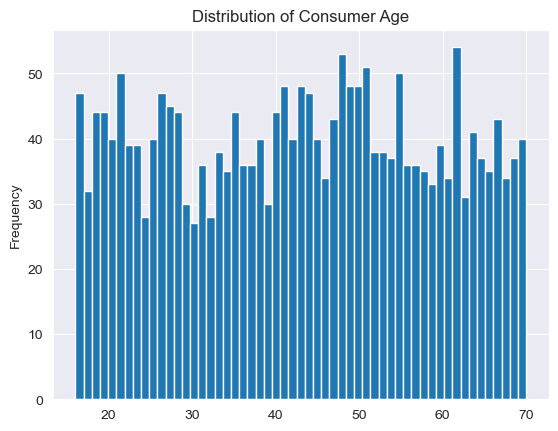

In [30]:
# distribution of consumer age
old['consumer_age'].plot(kind='hist', bins=55, title='Distribution of Consumer Age')

# most consumers teens - early 20s, 40s - 50s

In [35]:
old['consumer_age'].describe()
# avg consumer age of 43, youngest 16, oldest 70

count    2191.000000
mean       42.934277
std        15.780407
min        16.000000
25%        29.000000
50%        43.000000
75%        56.000000
max        70.000000
Name: consumer_age, dtype: float64

In [36]:
# explore values that are fraud
old_f = old.loc[old['fraud_flag'] == 1]
old_f.head()

,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age
488,1.0,9764,ip_6112,Windows NT,6.0,2021-04-26 15:12:37.127,Blue Shop,consumer_1799,2021-04-26 15:13:30.180,8550,email_00000001651@protonmail.ch,email_00000001651@protonmail.ch,819000006122,818000002920,3,0,0,7938102,NaN,18
605,1.0,9787,ip_6118,Windows NT,6.0,2021-04-26 17:28:22.729,Blue Shop,consumer_1809,2021-04-26 17:28:51.699,8250,email_0000000001450@protonmail.ch,email_0000000001450@protonmail.ch,819000005042,818000002907,171,0,0,8439047,Female,24
619,1.0,10081,ip_6281,Windows NT,6.0,2021-04-26 17:50:50.199,Blue Shop,consumer_1823,2021-04-26 17:51:46.984,8500,email_000000001395@protonmail.com,email_000000001395@protonmail.com,819000005831,818000002888,6,0,0,9068933,Male,67
648,1.0,2128,ip_1403,Windows NT,6.0,2021-04-26 18:08:30.236,Blue Shop,consumer_1837,2021-04-26 18:10:42.479,8800,email_000001389@protonmail.com,email_000001389@protonmail.com,819000005797,818000002901,106,0,0,9288155,Male,33
665,1.0,7380,ip_4694,Windows NT,6.0,2021-04-26 18:29:02.090,Blue Shop,consumer_1754,2021-04-26 18:29:31.191,8500,email_00000000001394@protonmail.com,email_00000000001394@protonmail.com,819000005831,818000002935,116,0,0,9068933,Female,48


In [37]:
# fraud rows where adjust_pmt_created_at is before adjusted_acc_created_at
old_f[old_f['adjusted_pmt_created_at'] < old_f['adjusted_acc_created_at']]

,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age
488,1.0,9764,ip_6112,Windows NT,6.0,2021-04-26 15:12:37.127,Blue Shop,consumer_1799,2021-04-26 15:13:30.180,8550,email_00000001651@protonmail.ch,email_00000001651@protonmail.ch,819000006122,818000002920,3,0,0,7938102,NaN,18
605,1.0,9787,ip_6118,Windows NT,6.0,2021-04-26 17:28:22.729,Blue Shop,consumer_1809,2021-04-26 17:28:51.699,8250,email_0000000001450@protonmail.ch,email_0000000001450@protonmail.ch,819000005042,818000002907,171,0,0,8439047,Female,24
619,1.0,10081,ip_6281,Windows NT,6.0,2021-04-26 17:50:50.199,Blue Shop,consumer_1823,2021-04-26 17:51:46.984,8500,email_000000001395@protonmail.com,email_000000001395@protonmail.com,819000005831,818000002888,6,0,0,9068933,Male,67
648,1.0,2128,ip_1403,Windows NT,6.0,2021-04-26 18:08:30.236,Blue Shop,consumer_1837,2021-04-26 18:10:42.479,8800,email_000001389@protonmail.com,email_000001389@protonmail.com,819000005797,818000002901,106,0,0,9288155,Male,33
665,1.0,7380,ip_4694,Windows NT,6.0,2021-04-26 18:29:02.090,Blue Shop,consumer_1754,2021-04-26 18:29:31.191,8500,email_00000000001394@protonmail.com,email_00000000001394@protonmail.com,819000005831,818000002935,116,0,0,9068933,Female,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,1.0,9746,ip_6105,Windows NT,10.0,2021-04-27 21:29:06.978,Blue Shop,consumer_3550,2021-04-27 21:31:50.745,8900,email_000000003764@gomen-da.com,email_000000003764@gomen-da.com,819000008045,819000008045,86,0,0,1103892,Male,34
2012,1.0,8167,ip_5162,Windows NT,10.0,2021-04-27 22:09:23.779,Blue Shop,consumer_3364,2021-04-27 22:10:37.561,7980,email_00000003775@gomen-da.com,email_00000003775@gomen-da.com,818000002931,818000002931,151,0,0,3256223,NaN,38
2027,1.0,8165,ip_5162,Windows NT,10.0,2021-04-27 22:13:58.663,Blue Shop,consumer_3375,2021-04-27 22:15:08.846,6186,email_000000003773@gomen-da.com,email_000000003773@gomen-da.com,818000002899,818000002899,71,0,0,3256223,Male,66
2040,1.0,8166,ip_5162,Windows NT,10.0,2021-04-27 22:17:13.536,Blue Shop,consumer_3380,2021-04-27 22:19:17.385,8010,email_000000003780@gomen-da.com,email_000000003780@gomen-da.com,818000002913,818000002913,59,0,0,5658128,Male,28


In [38]:
# fraud rows where hashed_buyer_email and hashed_consumer_email do not match
old_f[old_f['hashed_buyer_email'] != old_f['hashed_consumer_email']].shape

(18, 20)

In [39]:
# fraud rows where hashed_buyer_phone and hashed_consumer_phone do not match
old_f[old_f['hashed_buyer_phone'] != old_f['hashed_consumer_phone']].shape

(49, 20)

In [40]:
# fraud rows that don't have 'proton' in hashed_buyer_email
old_f[~old_f['hashed_buyer_email'].str.contains('proton')]
# fraud rows don't come from gmail accounts

,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age
847,1.0,2140,ip_1408,Windows NT,10.0,2021-04-26 21:12:56.203,Blue Shop,consumer_1869,2021-04-26 21:14:10.554,8639,email_0000005519@yahoo.co.jp,email_0000005519@yahoo.co.jp,818000004537,818000002914,150,0,0,9188966,Female,46
885,1.0,10054,ip_6273,Windows NT,10.0,2021-04-26 21:41:45.461,Blue Shop,consumer_1974,2021-04-26 21:42:46.140,7000,email_0000002688@yahoo.co.jp,email_0000002688@yahoo.co.jp,818000002915,818000002915,109,0,0,7588393,Male,44
927,1.0,7391,ip_4701,Windows NT,10.0,2021-04-26 22:14:01.290,Blue Shop,consumer_2087,2021-04-26 22:14:58.099,6355,email_0000007330@yahoo.co.jp,email_0000007330@yahoo.co.jp,818000002795,818000002923,111,0,0,6528114,Male,50
935,1.0,7392,ip_4701,Windows NT,10.0,2021-04-26 22:18:15.235,Blue Shop,consumer_2119,2021-04-26 22:19:00.722,7980,email_000007450@yahoo.co.jp,email_000007450@yahoo.co.jp,818000002909,818000002909,151,0,0,6528114,Female,18
1036,1.0,8163,ip_5161,Windows NT,10.0,2021-04-26 23:19:17.971,Blue Shop,consumer_1589,2021-04-26 23:21:20.693,7980,email_0000001763@yahoo.co.jp,email_0000001763@yahoo.co.jp,818000002922,818000002922,189,0,0,6528114,Male,26
1040,1.0,8164,ip_5161,Windows NT,10.0,2021-04-26 23:24:39.056,Blue Shop,consumer_1616,2021-04-26 23:26:38.727,7980,email_000007519@yahoo.co.jp,email_000007519@yahoo.co.jp,818000002902,818000002902,165,0,0,9188966,Female,47
1608,1.0,9762,ip_6111,Windows NT,10.0,2021-04-27 16:46:51.066,Blue Shop,consumer_3299,2021-04-27 16:48:27.620,7980,email_0000000682@yahoo.co.jp,email_0000000682@yahoo.co.jp,818000002968,818000002968,78,0,0,1208893,NaN,44
1613,1.0,9763,ip_6111,Windows NT,10.0,2021-04-27 16:52:41.103,Blue Shop,consumer_3308,2021-04-27 16:53:44.748,7980,email_0008221@yahoo.co.jp,email_0008221@yahoo.co.jp,818000002950,818000002950,30,0,0,1063816,NaN,62
1618,1.0,10086,ip_6285,Windows NT,10.0,2021-04-27 16:57:38.580,Blue Shop,consumer_3321,2021-04-27 16:58:54.647,8980,email_00004176@yahoo.co.jp,email_00004176@yahoo.co.jp,818000002892,818000002892,145,0,0,1063816,NaN,31
1624,1.0,10087,ip_6285,Windows NT,10.0,2021-04-27 17:02:34.313,Blue Shop,consumer_3327,2021-04-27 17:05:09.603,8980,email_0000000000712@yahoo.co.jp,email_0000000000712@yahoo.co.jp,818000002881,818000002881,103,0,0,7588393,Male,27


In [41]:
# fraud rows device count
old_f['device'].value_counts()
# all come from Windows NT devices (69/114 total)

device
Windows NT    69
Name: count, dtype: int64

In [42]:
# fraud rows merchant name count
old_f['merchant_name'].value_counts()
# all come from Blue Shop

merchant_name
Blue Shop    69
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of Purchase Amount'}, ylabel='Frequency'>

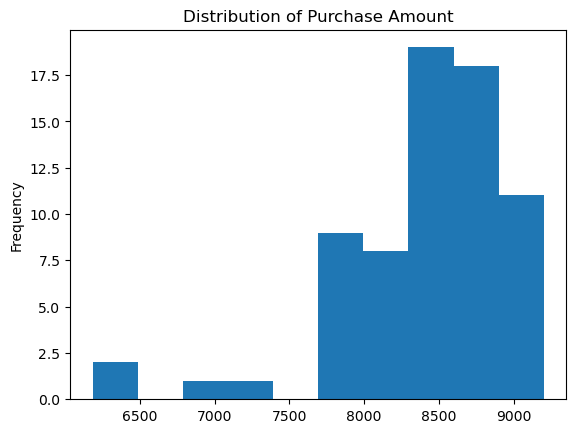

In [43]:
# distribution of purchase amount for fraud rows
old_f['amount'].plot(kind='hist', bins=10, title='Distribution of Purchase Amount')

In [44]:
old_f.describe()

,fraud_flag,payment_id,version,adjusted_pmt_created_at,adjusted_acc_created_at,amount,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_age
count,69.0,69.000000,69.000000,69,69,69.000000,6.900000e+01,6.900000e+01,69.000000,69.0,69.0,6.900000e+01,69.000000
mean,1.0,8445.927536,7.275362,2021-04-27 05:45:17.711057664,2021-04-27 05:46:32.471116032,8420.347826,8.180348e+11,8.183044e+11,103.217391,0.0,0.0,5.500574e+06,45.101449
min,1.0,2117.000000,6.000000,2021-04-26 15:12:37.127000,2021-04-26 15:13:30.180000,6186.000000,8.122000e+11,8.180000e+11,3.000000,0.0,0.0,1.063816e+06,18.000000
25%,1.0,8164.000000,6.000000,2021-04-26 21:09:05.624000,2021-04-26 21:09:24.355000064,8250.000000,8.180000e+11,8.180000e+11,55.000000,0.0,0.0,3.668113e+06,32.000000
50%,1.0,9749.000000,6.000000,2021-04-26 22:57:02.832999936,2021-04-26 22:58:50.678000128,8500.000000,8.180000e+11,8.180000e+11,110.000000,0.0,0.0,5.658128e+06,46.000000
75%,1.0,9786.000000,10.000000,2021-04-27 16:52:41.103000064,2021-04-27 16:53:44.748000,8800.000000,8.190000e+11,8.190000e+11,151.000000,0.0,0.0,7.958173e+06,58.000000
max,1.0,10109.000000,10.000000,2021-04-27 22:51:05.958000,2021-04-27 22:52:39.431000,9200.000000,8.190000e+11,8.190000e+11,197.000000,0.0,0.0,9.638140e+06,69.000000
std,0.0,2483.155028,1.877765,NaN,NaN,545.482378,1.568237e+09,4.635034e+08,56.877285,0.0,0.0,2.702598e+06,14.898820


<Axes: xlabel='consumer_age'>

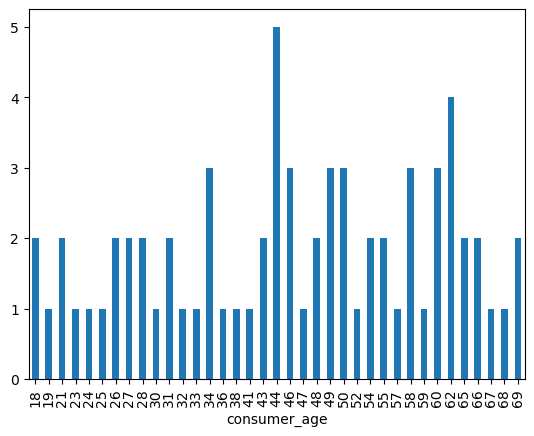

In [45]:
old_f['consumer_age'].value_counts().sort_index().plot(kind='bar')

In [46]:
old_f.head()

,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age
488,1.0,9764,ip_6112,Windows NT,6.0,2021-04-26 15:12:37.127,Blue Shop,consumer_1799,2021-04-26 15:13:30.180,8550,email_00000001651@protonmail.ch,email_00000001651@protonmail.ch,819000006122,818000002920,3,0,0,7938102,NaN,18
605,1.0,9787,ip_6118,Windows NT,6.0,2021-04-26 17:28:22.729,Blue Shop,consumer_1809,2021-04-26 17:28:51.699,8250,email_0000000001450@protonmail.ch,email_0000000001450@protonmail.ch,819000005042,818000002907,171,0,0,8439047,Female,24
619,1.0,10081,ip_6281,Windows NT,6.0,2021-04-26 17:50:50.199,Blue Shop,consumer_1823,2021-04-26 17:51:46.984,8500,email_000000001395@protonmail.com,email_000000001395@protonmail.com,819000005831,818000002888,6,0,0,9068933,Male,67
648,1.0,2128,ip_1403,Windows NT,6.0,2021-04-26 18:08:30.236,Blue Shop,consumer_1837,2021-04-26 18:10:42.479,8800,email_000001389@protonmail.com,email_000001389@protonmail.com,819000005797,818000002901,106,0,0,9288155,Male,33
665,1.0,7380,ip_4694,Windows NT,6.0,2021-04-26 18:29:02.090,Blue Shop,consumer_1754,2021-04-26 18:29:31.191,8500,email_00000000001394@protonmail.com,email_00000000001394@protonmail.com,819000005831,818000002935,116,0,0,9068933,Female,48


- fraud flags
    - merchant_account_age = 0
    - ltv = 0
    - merchant_name = 'Blue Shop'
    - device = 'Windows NT'
    - adjusted_pmt_created_at < adjusted_acc_created_at
    - emails do not contain gmail (yahoo, protonmail, gomen-da.com)
    - amount = [6186 - 9200]
    - age = [18 - 69]
    - 49/69 fraud flags do not have matching buyer and consumer phone numbers
    - 18/69 fraud flags do not have matching buyer and consumer email addresses

In [47]:
old.isna().sum()

fraud_flag                 2122
payment_id                    0
hashed_ip                     0
device                        9
version                       9
adjusted_pmt_created_at       0
merchant_name                 0
hashed_consumer_id            0
adjusted_acc_created_at       0
amount                        0
hashed_buyer_email            0
hashed_consumer_email         0
hashed_buyer_phone            0
hashed_consumer_phone         0
consumer_phone_age            0
merchant_account_age          0
ltv                           0
hashed_zip                    0
consumer_gender             513
consumer_age                  0
dtype: int64

In [48]:
# fraud row count by gender
old_f['consumer_gender'].value_counts()

consumer_gender
Male      29
Female    24
Name: count, dtype: int64

In [49]:
# identify variables that need transformation (log, normalize, outlier removal)
    # amount, merchant_account_age, ltv
        # amount can possibly be binned to see if a more normal distribution is possible
# identify variables that need imputation (mode, median, mean, other)
    # only gender has >9 values missing besides fraug_flag
        # does not seem to have correlation with fraud flag, will drop the feature
    # impute 0 for fraud_flag
    # drop rows with missing device and version (9 out of 2191 total, 0.4% of total rows)

# variable relationship w/ target variable (fraud_flag)
# use corr_ function to identify correlations

# proceeding with null values + outliers
    # which values to drop?
    # which values to impute?
    # which values to normalize?

In [50]:
def corr_(df, n = 0.85, x = 1):
    '''
    
    Input - df: dataframe
            n: lower limit of correlation
            x: upper limit of correlation
            
    Output - dataframe with correlated pairs and correlation values
    
    '''
    df_cc=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df_cc['pairs'] = list(zip(df_cc.level_0, df_cc.level_1))
    df_cc.set_index(['pairs'], inplace = True)
    df_cc.drop(columns=['level_1', 'level_0'], inplace = True)
    df_cc.columns = ['cc']
    df_cc.drop_duplicates(inplace=True)
    
    return df_cc[(df_cc['cc'] > n) & (df_cc['cc'] < x)]


In [51]:
corr_(old.drop(columns=['hashed_ip', 'device', 'merchant_name', 'hashed_consumer_id', 'hashed_buyer_email', 'hashed_consumer_email', 'consumer_gender']), n=0.8)

,cc
pairs,


In [52]:
# numerical columns are not showing strong correlation to each other or to target variable

## Proceeding with Null Values and Outliers

In [53]:
def find_outlier(df, feature):
    '''
    Input - dataframe, column/feature with outliers
    
    Output - quartile range, lower quartile, upper quartile 
    '''
       
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower = q1-(iqr*1.5)
    upper = q3+(iqr*1.5)
    result = f'Outlier range for {feature}:\n\tIQR: {iqr}\n\tLower: {lower}\n\tUpper: {upper}'
    return print(result)

In [54]:
find_outlier(old, 'amount')

Outlier range for amount:
	IQR: 13100.0
	Lower: -16750.0
	Upper: 35650.0


In [55]:
# determine data loss if amount outlier is removed
pct_outlier = len(old.loc[old['amount'] > 35650]) / len(old)
print(f"Rows removed: {len(old.loc[old['amount'] > 35650])}")
print(f"Removing outliers results in {round(pct_outlier*100, 2)}% of data loss")

# 9% loss is ok, but not ideal. will proceed to remove outliers based on IQR

Rows removed: 197
Removing outliers results in 8.99% of data loss


In [56]:
find_outlier(old, 'merchant_account_age')

Outlier range for merchant_account_age:
	IQR: 179.0
	Lower: -268.5
	Upper: 447.5


<Axes: title={'center': 'Distribution of Merchant Account Age'}, ylabel='Frequency'>

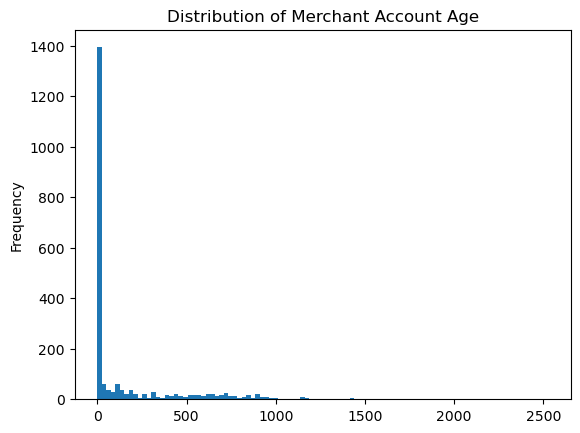

In [57]:
# distribution of merchant_account_age in old
old['merchant_account_age'].plot(kind='hist', bins=100, title='Distribution of Merchant Account Age')

In [58]:
# merchant_account_age values from largest to smallest
old.sort_values(by = 'merchant_account_age', ascending = False).head(20)

,fraud_flag,payment_id,hashed_ip,device,version,adjusted_pmt_created_at,merchant_name,hashed_consumer_id,adjusted_acc_created_at,amount,hashed_buyer_email,hashed_consumer_email,hashed_buyer_phone,hashed_consumer_phone,consumer_phone_age,merchant_account_age,ltv,hashed_zip,consumer_gender,consumer_age
1174,NaN,1273,ip_822,iPhone OS,13.0,2021-04-27 02:25:59.333,Red Shop,consumer_1127,2021-03-29 20:03:31.918,2980,email_0000000000000002895@gmail.com,email_0000000000000002895@gmail.com,819000007029,819000007029,191,2527,600,1247814,Male,57
959,NaN,8726,ip_5523,Android,9.0,2021-04-26 22:30:09.634,Red Shop,consumer_2163,2021-04-26 22:30:18.606,3800,email_00000000000005364@ezweb.ne.jp,email_0000772@au.com,818000003924,818000003924,85,2406,2300,6938913,Male,57
941,NaN,12732,ip_7856,iPhone OS,13.0,2021-04-26 22:21:08.231,Red Shop,consumer_163,2018-12-25 15:06:32.019,75000,email_00008262@gmail.com,email_000000001552@gmail.com,819000006909,818000004841,161,2336,5200,9178948,Female,33
1348,NaN,2031,ip_1330,iPhone OS,13.0,2021-04-27 11:15:13.021,Red Shop,consumer_3092,2021-04-27 11:15:21.919,3500,email_000005185@docomo.ne.jp,email_000005185@docomo.ne.jp,818000001154,818000001154,16,2288,1450,9148103,Male,57
1603,NaN,1184,ip_762,Android,10.0,2021-04-27 16:44:29.918,Red Shop,consumer_3290,2021-04-27 16:43:21.650,70300,email_0000000003401@yahoo.co.jp,email_0000000003401@yahoo.co.jp,818000003624,819000006762,22,2252,52300,4898114,Female,60
1597,NaN,1183,ip_762,Android,10.0,2021-04-27 16:43:12.337,Red Shop,consumer_3290,2021-04-27 16:43:21.650,70300,email_0000000003401@yahoo.co.jp,email_0000000003401@yahoo.co.jp,818000003624,819000006762,34,2252,52300,4898114,Male,70
1948,NaN,5739,ip_3654,iPhone OS,13.0,2021-04-27 21:37:57.872,Red Shop,consumer_3562,2021-04-27 21:38:15.697,9405,email_00003467@softbank.ne.jp,email_00003467@softbank.ne.jp,818000002044,818000002044,172,2231,2100,5729508,Female,55
1383,NaN,107,ip_81,iPhone OS,13.0,2021-04-27 12:28:18.120,Red Shop,consumer_3149,2021-04-27 12:29:53.730,1649,email_00000000000004753@ezweb.ne.jp,email_00000000000004753@ezweb.ne.jp,818000001764,818000001764,31,2165,5000,1213877,NaN,61
1141,NaN,6192,ip_3946,iPhone OS,13.0,2021-04-27 01:12:05.770,Red Shop,consumer_1380,2021-04-11 19:59:14.450,7500,email_003734@i.softbank.jp,email_003734@i.softbank.jp,818000002492,818000002492,182,2109,500,6876209,Male,65
1581,NaN,9449,ip_5942,Android,10.0,2021-04-27 16:25:34.817,Red Shop,consumer_3193,2021-04-27 13:31:16.135,19988,email_00004542@gmail.com,email_00004542@gmail.com,818000001662,818000001662,36,2086,2150,7138104,NaN,17


In [59]:
# determine data loss if merchant_account_age outlier is removed
pct_outlier = len(old.loc[old['merchant_account_age'] > 447.5]) / len(old)
print(f"Rows removed: {len(old.loc[old['merchant_account_age'] > 447.5])}")
print(f"Removing outliers results in {round(pct_outlier*100, 2)}% of data loss")

# 17% loss of data is too large. 
# change this to a binary of whether it is the first time purchase (merchant_account_age = 0) or not (merchant_account_age > 0)

Rows removed: 376
Removing outliers results in 17.16% of data loss


In [63]:
# create binary feature of if merchant_account_age is 0 or not
old['merchant_first_time'] = old['merchant_account_age'] == 0

C:\Users\scott\AppData\Local\Temp\ipykernel_39376\2985302822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old['merchant_first_time'] = old['merchant_account_age'] == 0


<Axes: xlabel='merchant_first_time'>

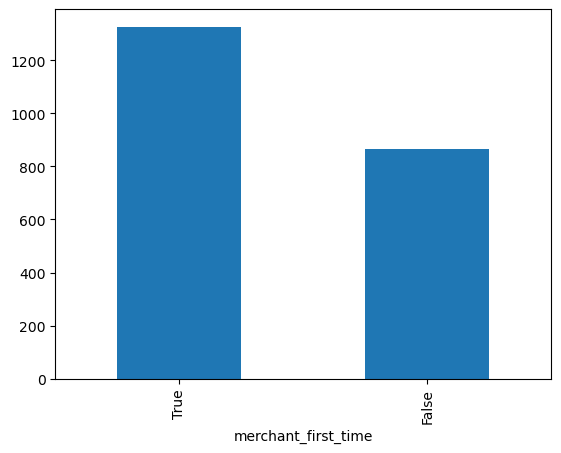

In [68]:
# plot of 'merchant_first_time' 
old['merchant_first_time'].value_counts().plot(kind='bar')

In [61]:
# Fill target column missing values with 0
old['fraud_flag'].fillna(0, inplace=True)

C:\Users\scott\AppData\Local\Temp\ipykernel_39376\1971506059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old['fraud_flag'].fillna(0, inplace=True)


In [62]:
# Feature engineering
# Extract features from 'adjusted_pmt_created_at'
old['payment_hour'] = old['adjusted_pmt_created_at'].dt.hour
old['payment_day'] = old['adjusted_pmt_created_at'].dt.day
old['payment_weekday'] = old['adjusted_pmt_created_at'].dt.weekday

# Extract features from 'adjusted_acc_created_at'
old['account_hour'] = old['adjusted_acc_created_at'].dt.hour
old['account_day'] = old['adjusted_acc_created_at'].dt.day
old['account_weekday'] = old['adjusted_acc_created_at'].dt.weekday

# Create feature for time between account creation and payment
old['time_diff'] = (old['adjusted_pmt_created_at'] - old['adjusted_acc_created_at']).dt.total_seconds()

# Create feature for if hashed_buyer_email and hashed_consumer_email are the same
old['same_email'] = old['hashed_buyer_email'] == old['hashed_consumer_email']

# Create feature for if hashed_buyer_phone and hashed_consumer_phone are the same
old['same_phone'] = old['hashed_buyer_phone'] == old['hashed_consumer_phone']

C:\Users\scott\AppData\Local\Temp\ipykernel_39376\3224967037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old['payment_hour'] = old['adjusted_pmt_created_at'].dt.hour
C:\Users\scott\AppData\Local\Temp\ipykernel_39376\3224967037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old['payment_day'] = old['adjusted_pmt_created_at'].dt.day
C:\Users\scott\AppData\Local\Temp\ipykernel_39376\3224967037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [71]:
columns=[
    'hashed_ip', 'device', 'merchant_name', 
    'hashed_consumer_id', 'hashed_buyer_email', 
    'hashed_consumer_email', 'consumer_gender']

In [72]:
corr_(old.drop(columns=columns), n = 0.85)

,cc
pairs,
"(payment_day, payment_weekday)",1.000000
"(time_diff, adjusted_acc_created_at)",0.999994
"(payment_day, adjusted_pmt_created_at)",0.873995
"(payment_weekday, adjusted_pmt_created_at)",0.873995


<Axes: title={'center': 'Distribution of Consumer Age'}, ylabel='Frequency'>

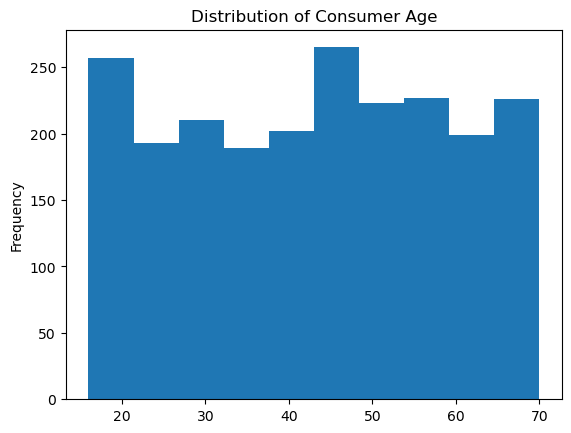

In [78]:
# plot of consumer_age
old['consumer_age'].plot(kind='hist', bins=10, title='Distribution of Consumer Age')


<Axes: title={'center': 'Distribution of Consumer Phone Age'}, ylabel='Frequency'>

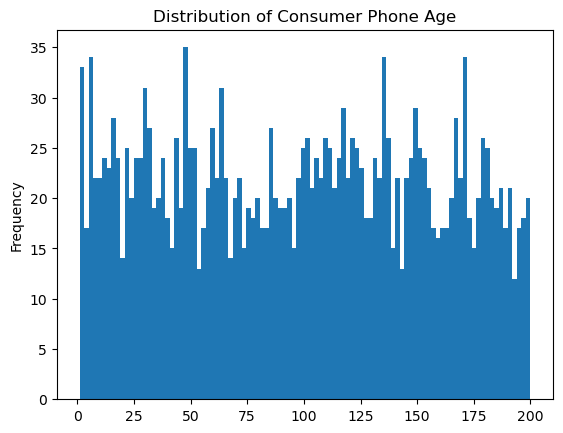

In [76]:
# plot of consumer_phone_age
old['consumer_phone_age'].plot(kind='hist', bins=100, title='Distribution of Consumer Phone Age')

In [60]:
# modeling data

# split data into train and test
    # do time series split?
    # use "future" events as test data

# determine feature importance
    # use feature selection
    # use recursive feature elimination
        # describe importance of each feature (does it make sense?)    
# use cross validation
# use pipelines to compare multiple models

# identify "best" performing model based off of cv results and:
    # accuracy
    # precision
    # auc
    # recall

# interpret model
    # shortcomings?
    # limitations?
    # future improvements?

● What features are predictive of fraud?
● Please propose the next step(s) based on your analysis.
● How would you monitor the proposed solution?
● What additional data points do you think could help with your decision?
● What else could you tell us about the data?
● What are the ML techniques you used and the reason you chose them?